In [1]:
# Install requirements
#!pip install -r requirements.txt | grep -v "already satisfied"

## Import Data

In [1]:
from src.helpers import setup_env

# this will download dataset (make sure you have at least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


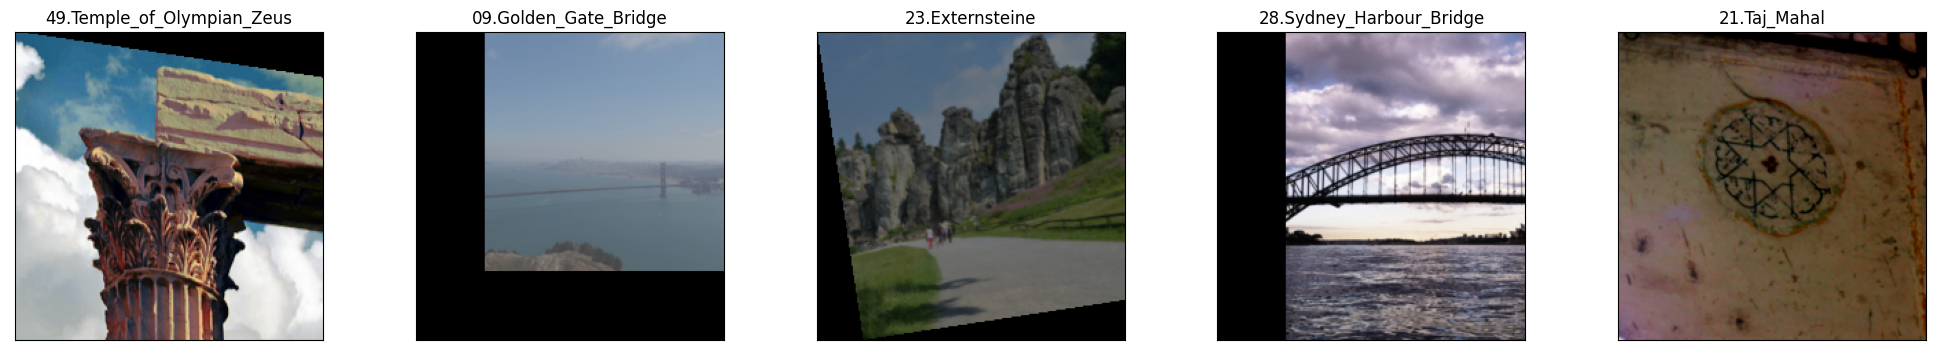

In [3]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(batch_size=5, valid_size=0.01)

visualize_one_batch(data_loaders)

## Training

In [13]:
batch_size = 64        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
num_epochs = 100       # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.4          # dropout for our model
learning_rate = 0.1  # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.0     # regularization. Increase this to combat overfitting

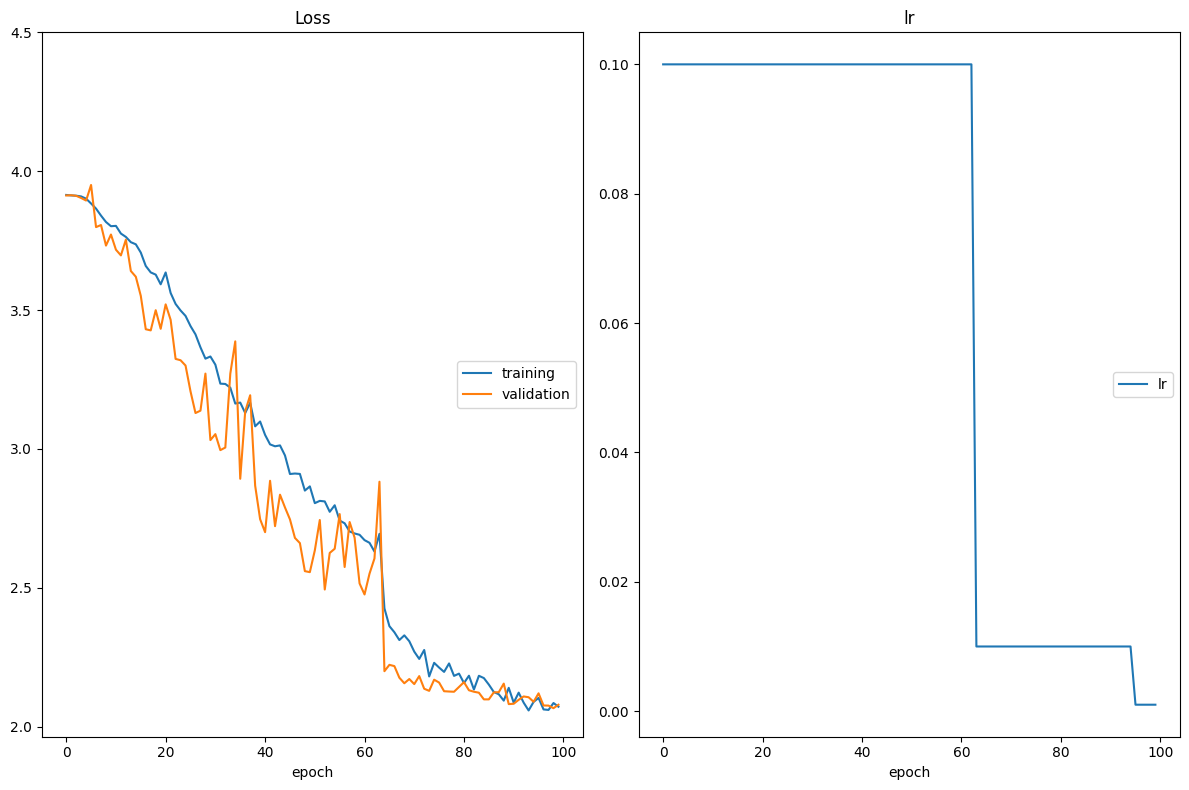

In [14]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# get the data loaders using batch_size and valid_size defined in the previous cell
data_loaders = get_data_loaders(batch_size=batch_size, valid_size=valid_size)

# instance model MyModel with num_classes and drouput defined in the previous cell
model = MyModel(num_classes=num_classes, dropout=dropout)

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(model=model, 
                          optimizer=opt, 
                          learning_rate=learning_rate, 
                          weight_decay=weight_decay)

# Get the loss using get_loss
loss = get_loss()

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    interactive_tracking=True
)

## Testing against Test Set

In [15]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

# load the weights in 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt'))

# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:01<00:00, 13.47it/s]

Test Loss: 1.804973


Test Accuracy: 53% (663/1250)


1.8049727857112887

Allright, now we are ready to export our model using our Predictor class:

In [17]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

class_names = data_loaders["train"].dataset.classes

# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt', map_location='cpu'))

# wrap model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)

scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [18]:
import torch

# Load using torch.jit.load
model_reloaded = torch.jit.load('checkpoints/original_exported.pt')

In [19]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

100%|██████████████████████████████████████| 1250/1250 [00:09<00:00, 129.77it/s]

Accuracy: 0.5264


## Confusion Matrix

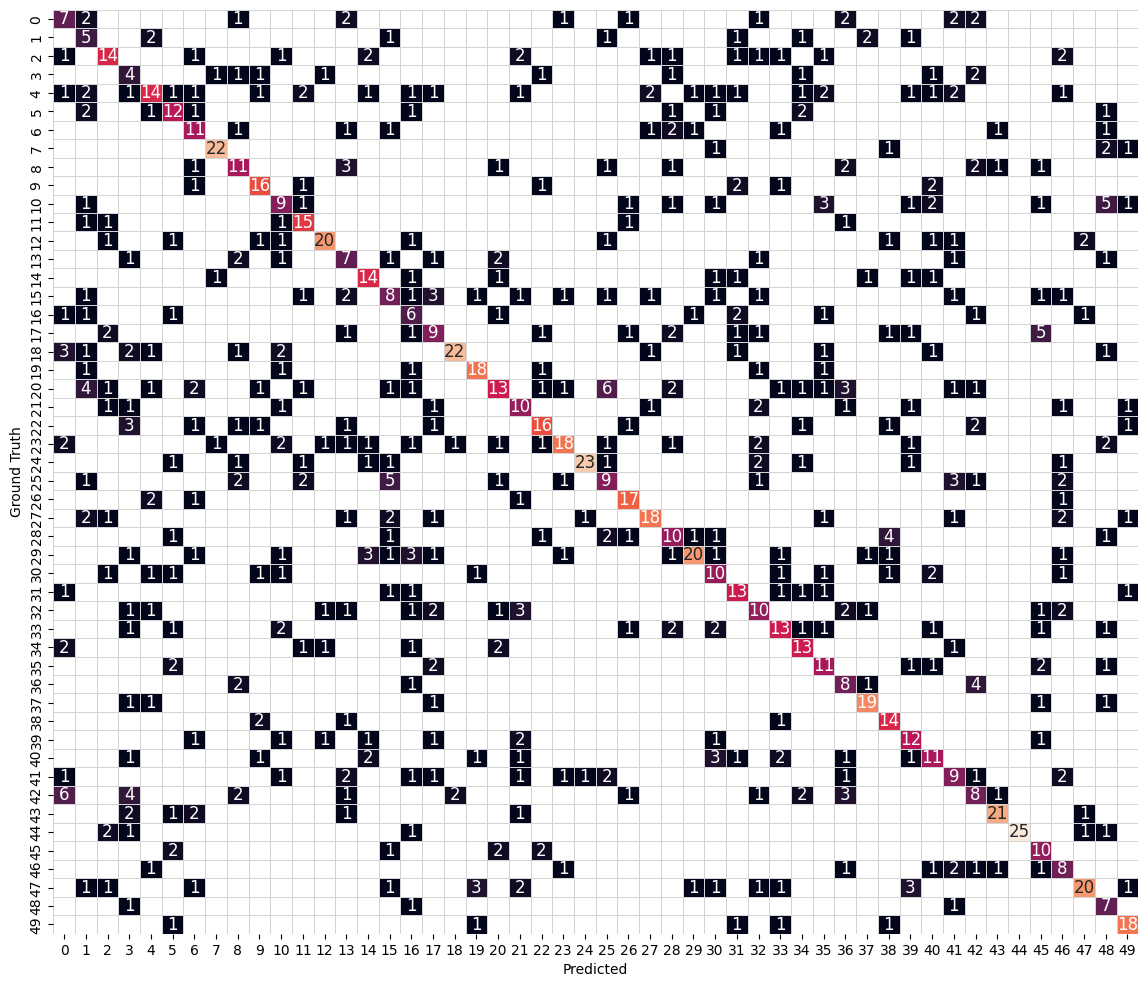

In [20]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)